# (06) Ablation -- ground truth

**Motivation**: Lesion bottom-up and top-down pathways. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# Code path
sys.path.insert(0, '/home/hadi/Documents/MTMST/code')
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
def lesion_results(tr: TrainerVAE, args: Iterable[str], dl_name: str = 'tst'):
    assert dl_name in ['trn', 'vld', 'tst']
    dl = getattr(tr, f"dl_{dl_name}")
    if dl is None:
        return
    if isinstance(args, str):
        args = [args]
    args = [f"lesion_{a}" for a in args]

    cos_lesion = collections.defaultdict(list)
    epe_lesion = collections.defaultdict(list)
    epe_normd = collections.defaultdict(list)
    y_lesion = collections.defaultdict(list)
    z_lesion = collections.defaultdict(list)
    z_infer = collections.defaultdict(list)

    for x, norm in iter(dl):
        for s, lesion in lesion_specs.items():
            kws = {'x': x, **{a: lesion for a in args}}
            latents, _, y, *_ = tr.model.xtract_ftr(**kws)
            latents = torch.cat(latents, dim=1).squeeze()
            z_lesion[s].append(to_np(latents))
            y_lesion[s].append(to_np(y))

            latents_infer = tr.model.xtract_ftr(y)[0]
            latents_infer = torch.cat(latents_infer, dim=1).squeeze()
            z_infer[s].append(to_np(latents_infer))

            epe_lesion[s].append(to_np(tr.model.loss_recon(
                x, y, w=1 / norm)))
            
            norm_x = torch.sum(torch.linalg.norm(
                x, dim=1, keepdims=True,
            ), dim=[2, 3], keepdims=True)
            norm_y = torch.sum(torch.linalg.norm(
                x, dim=1, keepdims=True,
            ), dim=[2, 3], keepdims=True)
            epe_normd[s].append(to_np(tr.model.loss_recon(
                x / norm_x, y / norm_y)))

            d = 1 - torch.mean(F.cosine_similarity(
                x, y, dim=1), dim=[1, 2])
            cos_lesion[s].append(to_np(d))

    output = {
        'cos_lesion': _cat_dict(cos_lesion),
        'epe_lesion': _cat_dict(epe_lesion),
        'epe_normd': _cat_dict(epe_normd),
        'y_lesion': _cat_dict(y_lesion),
        'z_lesion': _cat_dict(z_lesion),
        'z_infer': _cat_dict(z_infer),
    }
    return output


def _cat_dict(d):
    return {
        k: np.concatenate(v)
        for k, v in d.items()
    }

In [3]:
fig_dir = pjoin(fig_base_dir, 'rebuttal_aug')
print(fig_dir)

/home/hadi/Dropbox/git/jb-MTMST/figs/rebuttal_aug

In [4]:
tr = 'fixate1_nf-420_beta-0.15_(2023_04_27,20:20)'
tr = pjoin(results_dir(tr), 'Trainer')
tr = load_model_lite(tr, 'cuda')[0]

In [5]:
z = {
    k: tr.forward(k, True)[0]['z']
    for k in ['vld', 'tst']
}
epe = tr.forward('tst', True)[1]['epe']

## Train true decoder

In [6]:
grouped_lbl = dict(
    Fixation=['fix_x', 'fix_y'],
    Self_vel=['slf_v_x', 'slf_v_y', 'slf_v_z'],
    Obj_vel=['obj0_v_x', 'obj0_v_y', 'obj0_v_z'],
    Obj_pos=['obj0_x', 'obj0_y', 'obj0_z'],
)
g, select_lbl = prep_rofl('fixate1')
print(
    {k: v.shape for k, v in g.items()},
    select_lbl == list(LBL2TEX),
)

{'trn': (600000, 11), 'vld': (75000, 11), 'tst': (75000, 11)}
True

In [7]:
lr_true = sk_linear.LinearRegression().fit(z['vld'], g['vld'])
r2_true = sk_metric.r2_score(
    y_true=g['tst'],
    y_pred=lr_true.predict(z['tst']),
    multioutput='raw_values',
)
msg = f"true r2 mean: {r2_true.mean():0.4f}\n\n"
msg += ', '.join([f"{k}: {v:0.3f}" for k, v in zip(select_lbl, r2_true)])
print(msg)

true r2 mean: 0.8979

fix_x: 0.990, fix_y: 0.991, slf_v_x: 0.990, slf_v_y: 0.961, slf_v_z: 0.996, obj0_x: 0.934, 
obj0_y: 0.930, obj0_z: 0.847, obj0_v_x: 0.737, obj0_v_y: 0.818, obj0_v_z: 0.683

## Lesioned recons/latents

In [8]:
scales, _ = tr.model.latent_scales()
lesion_specs = {
    s: [s == item for item in scales]
    for s in np.unique(scales)
}

In [9]:
%%time

df_r2, df_epe, df_cos = [], [], []
for which in ['enc', 'dec', ('enc', 'dec')]:
    results = lesion_results(tr, which)
    if isinstance(which, tuple):
        which = 'both'
    for s in [2, 4, 8]:
        for z_mode in ['z_lesion', 'z_infer']:
            pred = lr_true.predict(results[z_mode][s])
            r2 = sk_metric.r2_score(
                y_pred=pred,
                y_true=g['tst'],
                multioutput='raw_values',
            )
            df_r2.append({
                'which': [which] * len(r2),
                'scale': [s] * len(r2),
                'z_mode': [z_mode] * len(r2),
                'factor': select_lbl,
                'r2': r2,
            })
        df_epe.append({
            'which': [which] * len(epe),
            'scale': [s] * len(epe),
            'sample_i': range(len(epe)),
            'epe_normd': results['epe_normd'][s],
            'epe_lesion': results['epe_lesion'][s],
        })
        df_cos.append({
            'which': [which] * len(epe),
            'scale': [s] * len(epe),
            'sample_i': range(len(epe)),
            'cos_lesion': results['cos_lesion'][s],
        })

df_cos = pd.DataFrame(merge_dicts(df_cos))
df_epe = pd.DataFrame(merge_dicts(df_epe))
df_r2 = pd.DataFrame(merge_dicts(df_r2))

CPU times: user 4min 41s, sys: 18.6 s, total: 5min
Wall time: 4min 51s


In [10]:
# compute error
err = np_nans(len(df_r2))
delta = np_nans(len(df_r2))
for i, k in enumerate(select_lbl):
    cond = df_r2['factor'] == k
    val = df_r2.loc[cond, 'r2']
    bsln = r2_true[i]
    err[cond] = bsln - val
    delta[cond] = 100 * (val - bsln) / bsln
df_r2['err'] = err
df_r2['delta'] = delta

# add grouped labels
group = np.zeros(len(df_r2), dtype=object)
for lbl, v in grouped_lbl.items():
    group[df_r2['factor'].isin(v)] = lbl
df_r2.insert(
    column='group',
    value=group,
    loc=4,
)

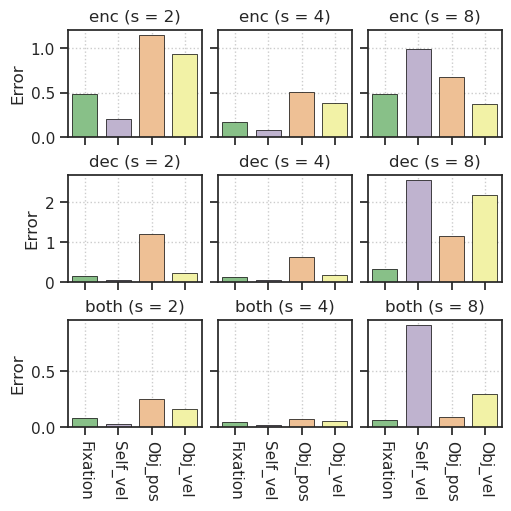

In [11]:
_df = df_r2.loc[df_r2['z_mode'] == 'z_infer']
fig, axes = create_figure(3, 3, (5, 5), 'all', 'row', layout='constrained')
for i, which in enumerate(_df['which'].unique()):
    for j, s in enumerate(_df['scale'].unique()):
        ax = axes[i, j]
        ax.set_title(f"{which} (s = {s})")
        sns.barplot(
            data=_df.loc[
                (_df['scale'] == s) &
                (_df['which'] == which)],
            width=0.75,
            hue='group',
            x='group',
            y='err',
            palette='Accent',
            errorbar=None,
            dodge=False,
            ax=ax,
        )
        move_legend(ax)
        ax.set(
            xlabel='',
            ylabel='Error' if j == 0 else '',
        )
        if i == 2:
            ax.tick_params(
                axis='x',
                rotation=-90,
            )
        plt.setp(
            ax.patches,
            linewidth=0.5,
            edgecolor='k',
        )
        ax.grid()
plt.show()

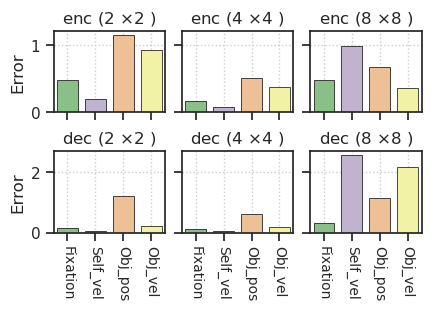

In [12]:
_df = df_r2.loc[df_r2['z_mode'] == 'z_infer']
fig, axes = create_figure(2, 3, (4.2, 3), 'all', 'row', layout='constrained')
for i, which in enumerate(['enc', 'dec']):
    for j, s in enumerate(_df['scale'].unique()):
        ax = axes[i, j]
        ax.set_title(f"{which} ({s} " + r"$\times$" + f"{s} )") # f"{which} (s = {s})")
        sns.barplot(
            data=_df.loc[
                (_df['scale'] == s) &
                (_df['which'] == which)],
            width=0.75,
            hue='group',
            x='group',
            y='err',
            palette='Accent',
            errorbar=None,
            dodge=False,
            ax=ax,
        )
        move_legend(ax)
        ax.set(
            xlabel='',
            ylabel='Error' if j == 0 else '',
        )
        if i == 1:
            ax.tick_params(
                axis='x',
                rotation=-90,
                labelsize=10,
            )
        plt.setp(
            ax.patches,
            linewidth=0.5,
            edgecolor='k',
        )
        ax.grid()
plt.show()

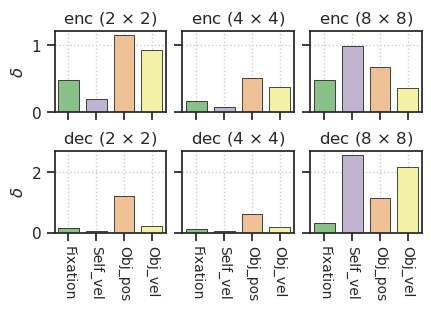

In [13]:
_df = df_r2.loc[df_r2['z_mode'] == 'z_infer']
fig, axes = create_figure(2, 3, (4.2, 3), 'all', 'row', layout='constrained')
for i, which in enumerate(['enc', 'dec']):
    for j, s in enumerate(_df['scale'].unique()):
        ax = axes[i, j]
        ax.set_title(f"{which} ({s} " + r"$\times$" + f" {s})") # f"{which} (s = {s})")
        sns.barplot(
            data=_df.loc[
                (_df['scale'] == s) &
                (_df['which'] == which)],
            width=0.75,
            hue='group',
            x='group',
            y='err',
            palette='Accent',
            errorbar=None,
            dodge=False,
            ax=ax,
        )
        move_legend(ax)
        ax.set(
            xlabel='',
            ylabel='', # + ' [%]' if j == 0 else '',
        )
        if i == 1:
            ax.tick_params(
                axis='x',
                rotation=-90,
                labelsize=10,
            )
        if j == 0:
            ax.set_ylabel(r'$\delta$')
        plt.setp(
            ax.patches,
            linewidth=0.5,
            edgecolor='k',
        )
        ax.grid()
fig.savefig(pjoin(fig_dir, 'lesion_r2_err.pdf'), bbox_inches='tight')
plt.show()

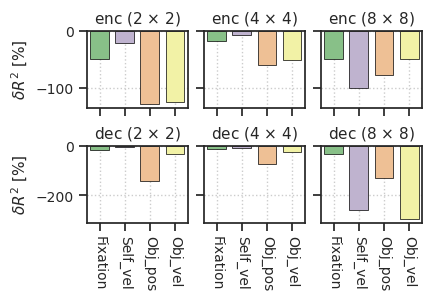

In [14]:
_df = df_r2.loc[df_r2['z_mode'] == 'z_infer']
fig, axes = create_figure(2, 3, (4.2, 2.9), 'all', 'row', layout='constrained')
for i, which in enumerate(['enc', 'dec']):
    for j, s in enumerate(_df['scale'].unique()):
        ax = axes[i, j]
        ax.set_title(f"{which} ({s} " + r"$\times$" + f" {s})", fontsize=11) # f"{which} (s = {s})")
        sns.barplot(
            data=_df.loc[
                (_df['scale'] == s) &
                (_df['which'] == which)],
            width=0.75,
            hue='group',
            x='group',
            y='delta',
            palette='Accent',
            errorbar=None,
            dodge=False,
            ax=ax,
        )
        move_legend(ax)
        ax.set(
            xlabel='',
            ylabel='', # + ' [%]' if j == 0 else '',
        )
        if i == 1:
            ax.tick_params(
                axis='x',
                rotation=-90,
                labelsize=10,
            )
        if j == 0:
            ax.tick_params(
                axis='y',
                labelsize=10,
            )
            ax.set_ylabel(r'$\delta R^2 \,\, \left[\%\right]$', fontsize=11)
        plt.setp(
            ax.patches,
            linewidth=0.5,
            edgecolor='k',
        )
        ax.grid()
fig.savefig(pjoin(fig_dir, 'lesion_r2_delta.pdf'), bbox_inches='tight')
plt.show()

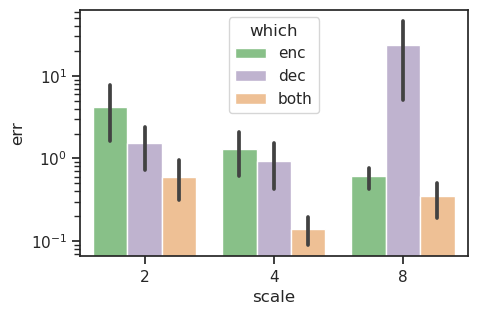

In [18]:
ax = sns.barplot(data=df_r2, x='scale', y='err', hue='which', palette='Accent')
ax.set_yscale('log')

In [19]:
df_r2.groupby(['z_mode', 'which', 'scale']).mean()

r2        err
z_mode   which scale                      
z_infer  both  2       0.763217   0.134658
               4       0.851442   0.046434
               8       0.530104   0.367771
         dec   2       0.469327   0.428548
               4       0.640828   0.257048
               8      -0.759877   1.657753
         enc   2       0.185238   0.712637
               4       0.602740   0.295136
               8       0.255480   0.642395
z_lesion both  2      -0.164200   1.062076
               4       0.665322   0.232554
               8       0.569220   0.328655
         dec   2      -1.721124   2.619000
               4      -0.690449   1.588325
               8     -45.274985  46.172861
         enc   2      -6.884153   7.782029
               4      -1.375197   2.273073
               8       0.334334   0.563542

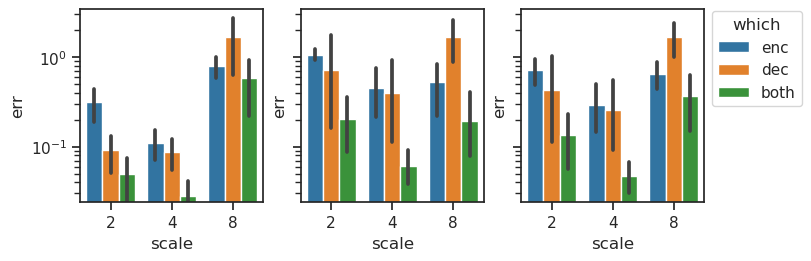

In [20]:
_df = df_r2.loc[df_r2['z_mode'] == 'z_infer']
fig, axes = create_figure(1, 3, (8, 2.5), 'all', 'all', 'constrained')

_f = [
    f for f in select_lbl
    if 'obj' not in f
]
ax = axes[0]
sns.barplot(
    data=_df.loc[_df['factor'].isin(_f)],
    hue='which',
    x='scale',
    y='err',
    ax=ax,
)
leg = ax.get_legend()
leg.remove()

_f = [
    f for f in select_lbl
    if 'obj' in f
]
ax = axes[1]
sns.barplot(
    data=_df.loc[_df['factor'].isin(_f)],
    hue='which',
    x='scale',
    y='err',
    ax=ax,
)
leg = ax.get_legend()
leg.remove()

ax = axes[-1]
sns.barplot(
    data=_df,
    hue='which',
    x='scale',
    y='err',
    ax=ax,
)
ax.set_yscale('log')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0, 1.03))
plt.show()

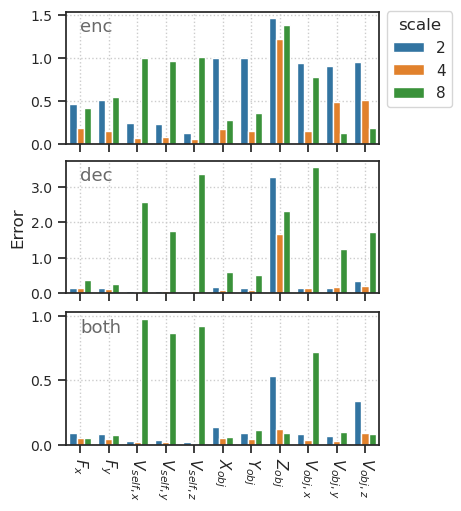

In [21]:
_df = df_r2.loc[df_r2['z_mode'] == 'z_infer']
fig, axes = create_figure(3, 1, (4.5, 5), sharex='all', layout='constrained')
for i, which in enumerate(_df['which'].unique()):
    ax = axes[i]
    sns.barplot(
        data=_df.loc[_df['which'] == which],
        order=LBL2TEX,
        width=0.75,
        hue='scale',
        x='factor',
        y='err',
        ax=ax,
    )
    ax.annotate(
        text=which,
        xy=(0.045, 0.85),
        xycoords='axes fraction',
        color='dimgrey',
        fontsize=13,
    )

ax = axes[2]
ax.set(
    xticklabels=LBL2TEX.values(),
    yscale='linear',
)
ax.tick_params(axis='x', rotation=-90)

for i, ax in enumerate(axes.flat):
    leg = ax.get_legend()
    if i == 0:
        move_legend(ax, (1.0, 1.06))
    else:
        move_legend(ax)
    ax.tick_params(axis='y', labelsize=10)
    ax.yaxis.set_major_formatter(
        matplotlib.ticker.FormatStrFormatter('%.1f'))
    ax.set(xlabel='', ylabel='Error' if i == 1 else '')#r"$R^2$" + ' drop')
    ax.grid()

plt.show()

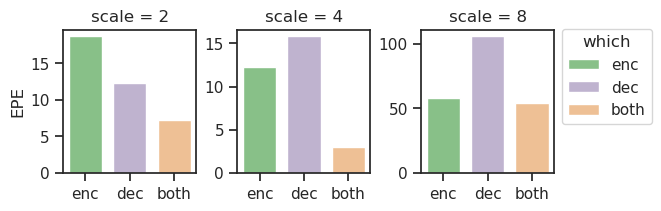

In [24]:
fig, axes = create_figure(1, 3, (6.5, 2), layout='constrained')
for i, s in enumerate(df_epe['scale'].unique()):
    ax = axes[i]
    ax.set_title(f'scale = {s}')
    sns.barplot(
        data=df_epe.loc[df_epe['scale'] == s],
        width=0.75,
        hue='which',
        x='which',
        y='epe_lesion',
        palette='Accent',
        errorbar=None,
        dodge=False,
        ax=ax,
    )
    if i == 2:
        move_legend(ax, (1.0, 1.06))
    else:
        move_legend(ax)
    ax.set(xlabel='', ylabel='')
    if i == 0:
        ax.set_ylabel('EPE')
plt.show()

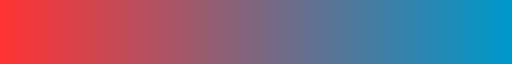

In [11]:
pal_lesion = {
    'enc': '#FF3333',
    'dec': '#0099CC',
}
make_cmap([
    to_rgb(c) for c in
    pal_lesion.values()
], show=False)

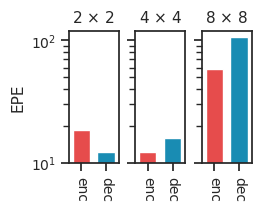

In [12]:
_df = df_epe.loc[df_epe['which'] != 'both']
fig, axes = create_figure(1, 3, (2.5, 2), 'all', 'all', layout='constrained')
for i, s in enumerate(_df['scale'].unique()):
    ax = axes[i]
    ax.set_title(f"{s} " + r"$\times$" + f" {s}", fontsize=11)
    sns.barplot(
        data=_df.loc[_df['scale'] == s],
        width=0.70,
        hue='which',
        x='which',
        y='epe_lesion',
        palette=pal_lesion,
        errorbar=None,
        dodge=False,
        ax=ax,
    )
    move_legend(ax)
    ax.set(
        xlabel='',
        ylabel='',
        yscale='log',
        ylim=(10, 120),
    )
    ax.tick_params(
        axis='both',
        labelsize=10,
    )
    ax.tick_params(
        axis='x',
        rotation=-90,
    )
    if i == 0:
        ax.set_ylabel('EPE', fontsize=11)
# fig.savefig(pjoin(fig_dir, 'lesion_epe.pdf'), bbox_inches='tight')
plt.show()

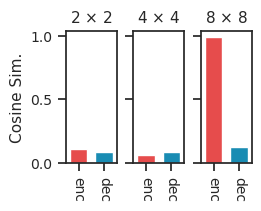

In [17]:
_df = df_cos.loc[df_cos['which'] != 'both']
fig, axes = create_figure(1, 3, (2.5, 2), 'all', 'all', layout='constrained')
for i, s in enumerate(_df['scale'].unique()):
    ax = axes[i]
    ax.set_title(f"{s} " + r"$\times$" + f" {s}", fontsize=11)
    sns.barplot(
        data=_df.loc[_df['scale'] == s],
        width=0.70,
        hue='which',
        x='which',
        y='cos_lesion',
        palette=pal_lesion,
        errorbar=None,
        dodge=False,
        ax=ax,
    )
    move_legend(ax)
    ax.set(
        xlabel='',
        ylabel='',
        yscale='linear',
        # ylim=(-100, 0),
    )
    ax.tick_params(
        axis='both',
        labelsize=10,
    )
    ax.tick_params(
        axis='x',
        rotation=-90,
    )
    if i == 0:
        ax.set_ylabel('Cosine Sim.', fontsize=11)
fig.savefig(pjoin(fig_dir, 'lesion_cos.pdf'), bbox_inches='tight')
plt.show()

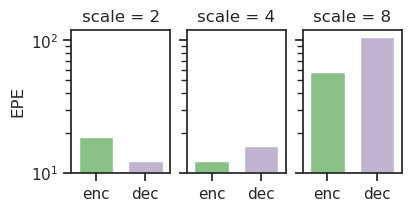

In [44]:
_df = df_epe.loc[df_epe['which'] != 'both']
fig, axes = create_figure(1, 3, (4, 2), sharey='all', layout='constrained')
for i, s in enumerate(_df['scale'].unique()):
    ax = axes[i]
    ax.set_title(f'scale = {s}')
    sns.barplot(
        data=_df.loc[_df['scale'] == s],
        width=0.70,
        hue='which',
        x='which',
        y='epe_lesion',
        palette='Accent',
        errorbar=None,
        dodge=False,
        ax=ax,
    )
    move_legend(ax)
    ax.set(
        xlabel='',
        ylabel='',
        yscale='log',
        ylim=(10, 120),
    )
    if i == 0:
        ax.set_ylabel('EPE')

plt.show()

## Show recon optic flow (lesion)

In [68]:
y_lesion = {}
for which in ['enc', 'dec']:
    y_lesion[which] = lesion_results(tr, which)['y_lesion']

In [71]:
x2p = to_np(tr.dl_tst.dataset.x)
x2p = {
    'enc': [x2p] + list(y_lesion['enc'].values()),
    'dec': [x2p] + list(y_lesion['dec'].values()),
}
x2p = {k: np.stack(v) for k, v in x2p.items()}
print({k: v.shape for k, v in x2p.items()})

{'enc': (4, 75000, 2, 17, 17), 'dec': (4, 75000, 2, 17, 17)}

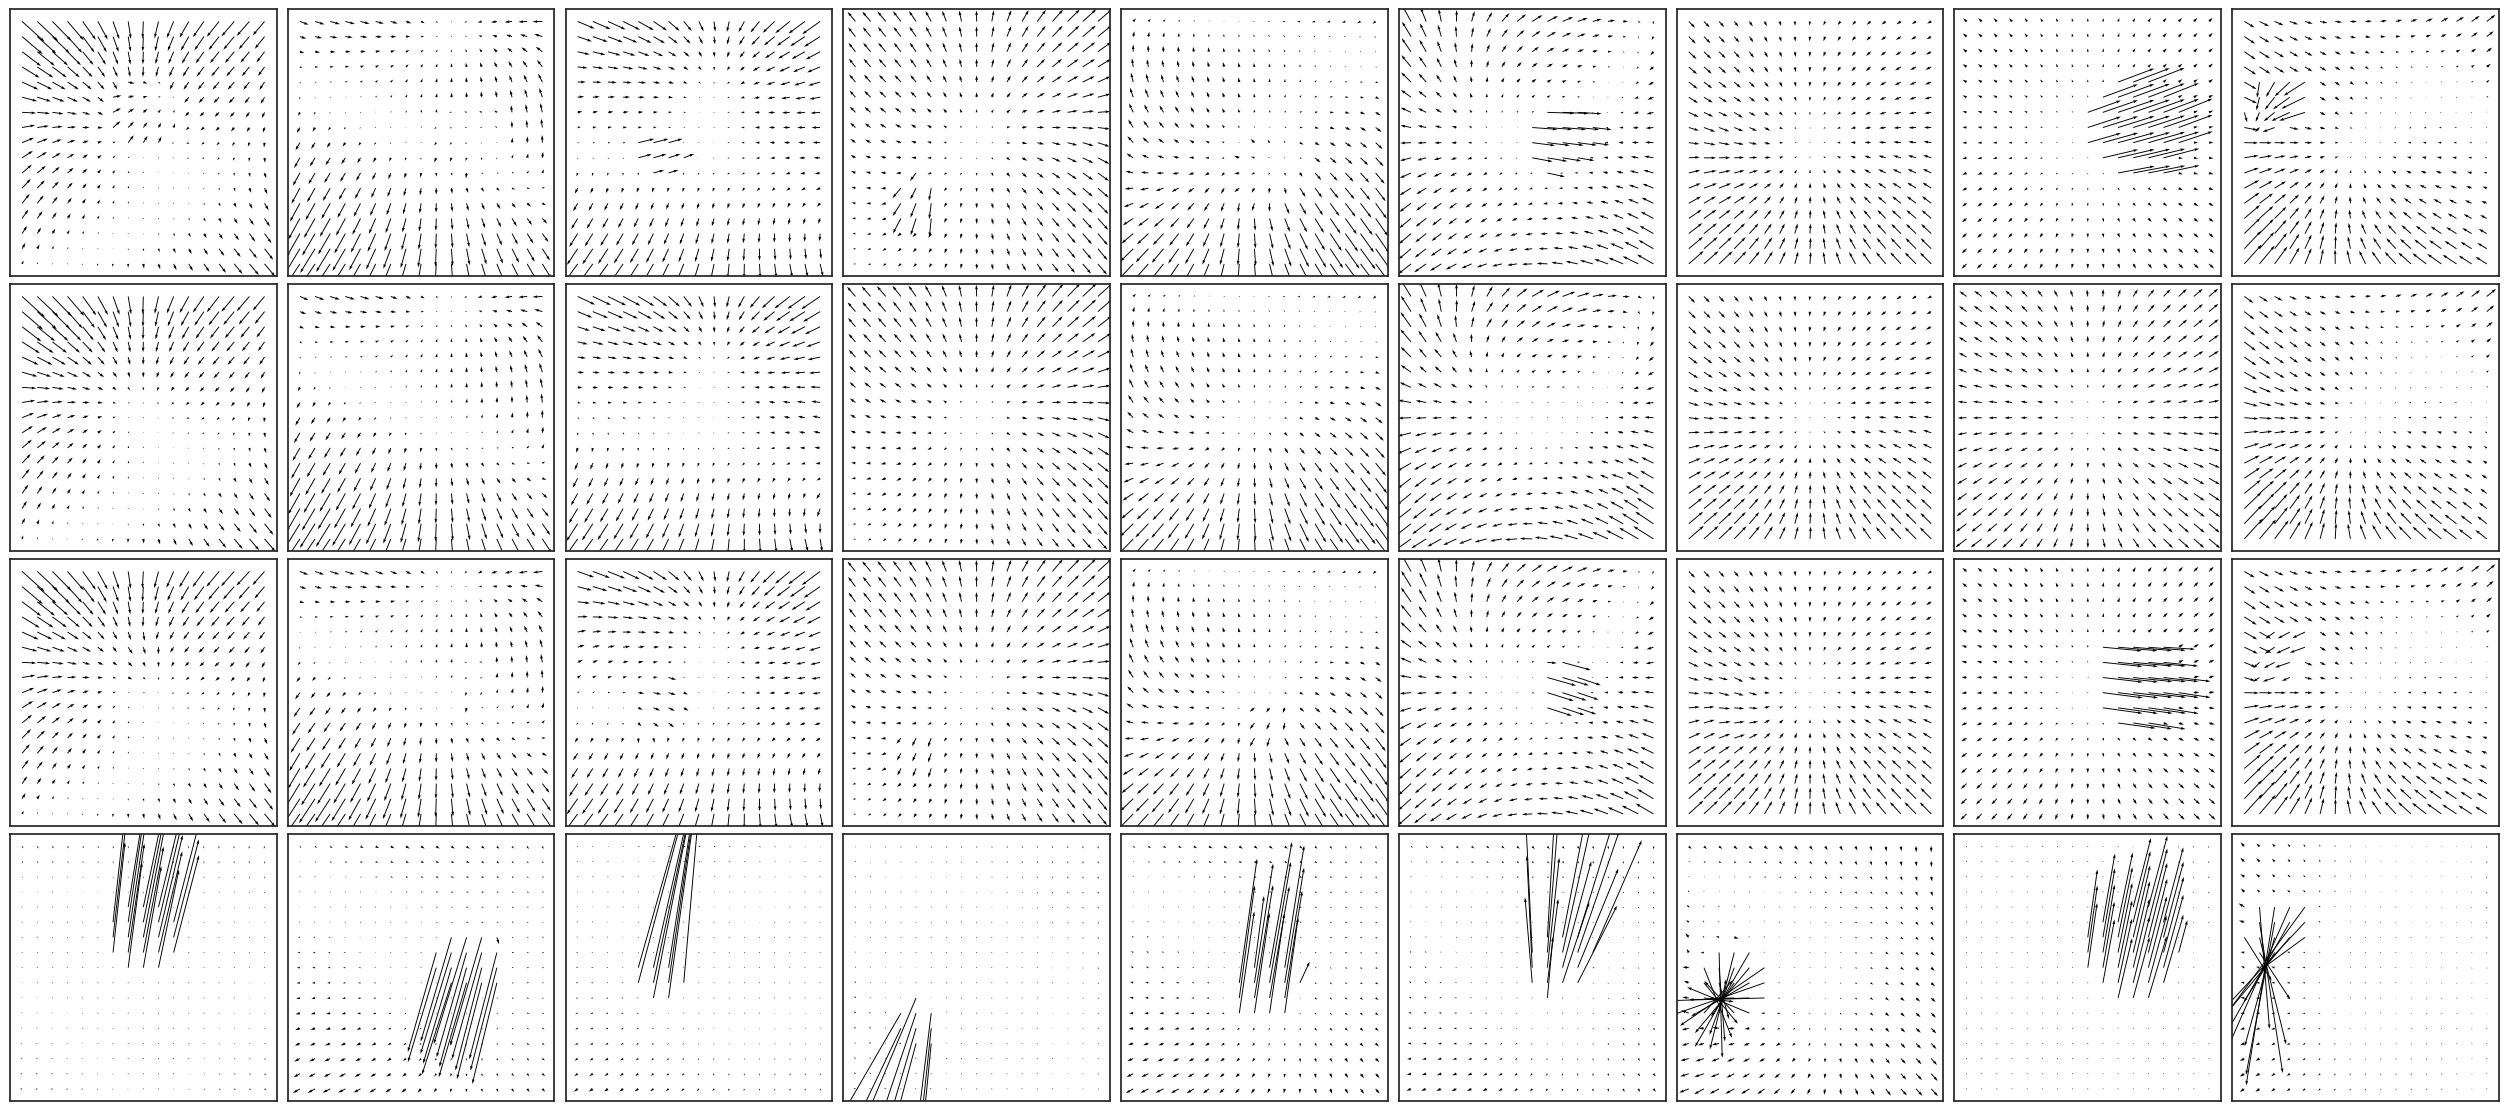

In [79]:
fig, axes = show_opticflow_row(x2p['enc'][:, 18:27], figsize=(25, 11))

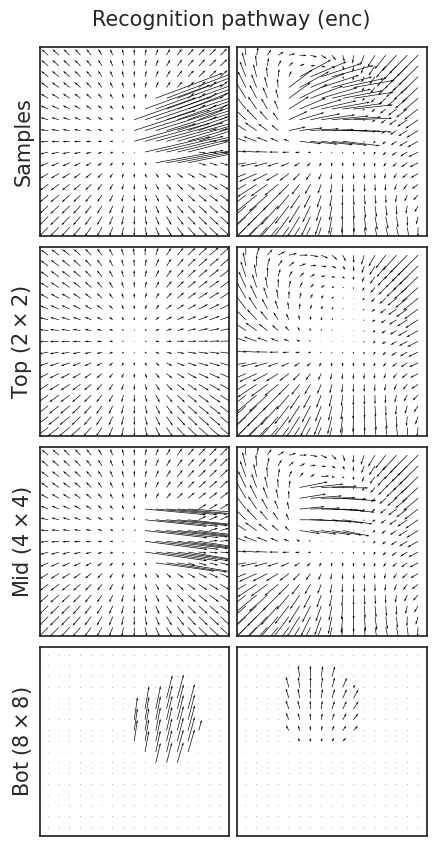

In [112]:
fig, axes = show_opticflow_row(x2p['enc'][:, [25, 13]], figsize=(4.25, 8), scale=[4, 3], display=False)

sup = fig.suptitle('Recognition pathway (enc)', fontsize=15, y=1.04, x=0.53)
axes[0, 0].set_ylabel('Samples', fontsize=15)
axes[1, 0].set_ylabel('Top ' + r"$\left(2 \times 2\right)$", fontsize=15)
axes[2, 0].set_ylabel('Mid ' + r"$\left(4 \times 4\right)$", fontsize=15)
axes[3, 0].set_ylabel('Bot ' + r"$\left(8 \times 8\right)$", fontsize=15)
fig.savefig(
    fname=pjoin(fig_dir, 'lesion_enc_2xsamples.pdf'),
    bbox_extra_artists=[sup],
    bbox_inches='tight',
)
display(fig)

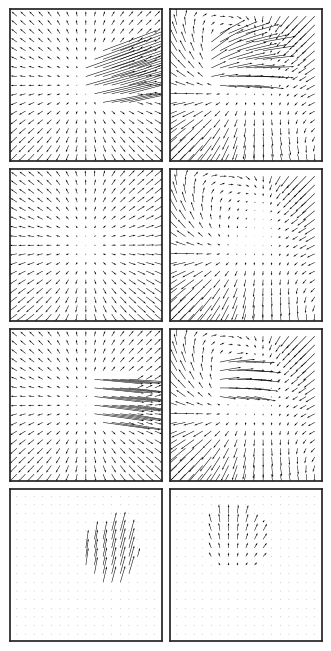

In [147]:
fig, axes = show_opticflow_row(x2p['enc'][:, [25, 13]], figsize=(3.2, 6.4), scale=[4, 3], no_ticks=True)
fig.savefig(
    fname=pjoin(fig_dir, 'lesion_enc_2xsamples_nolabels.pdf'),
    bbox_inches='tight',
)

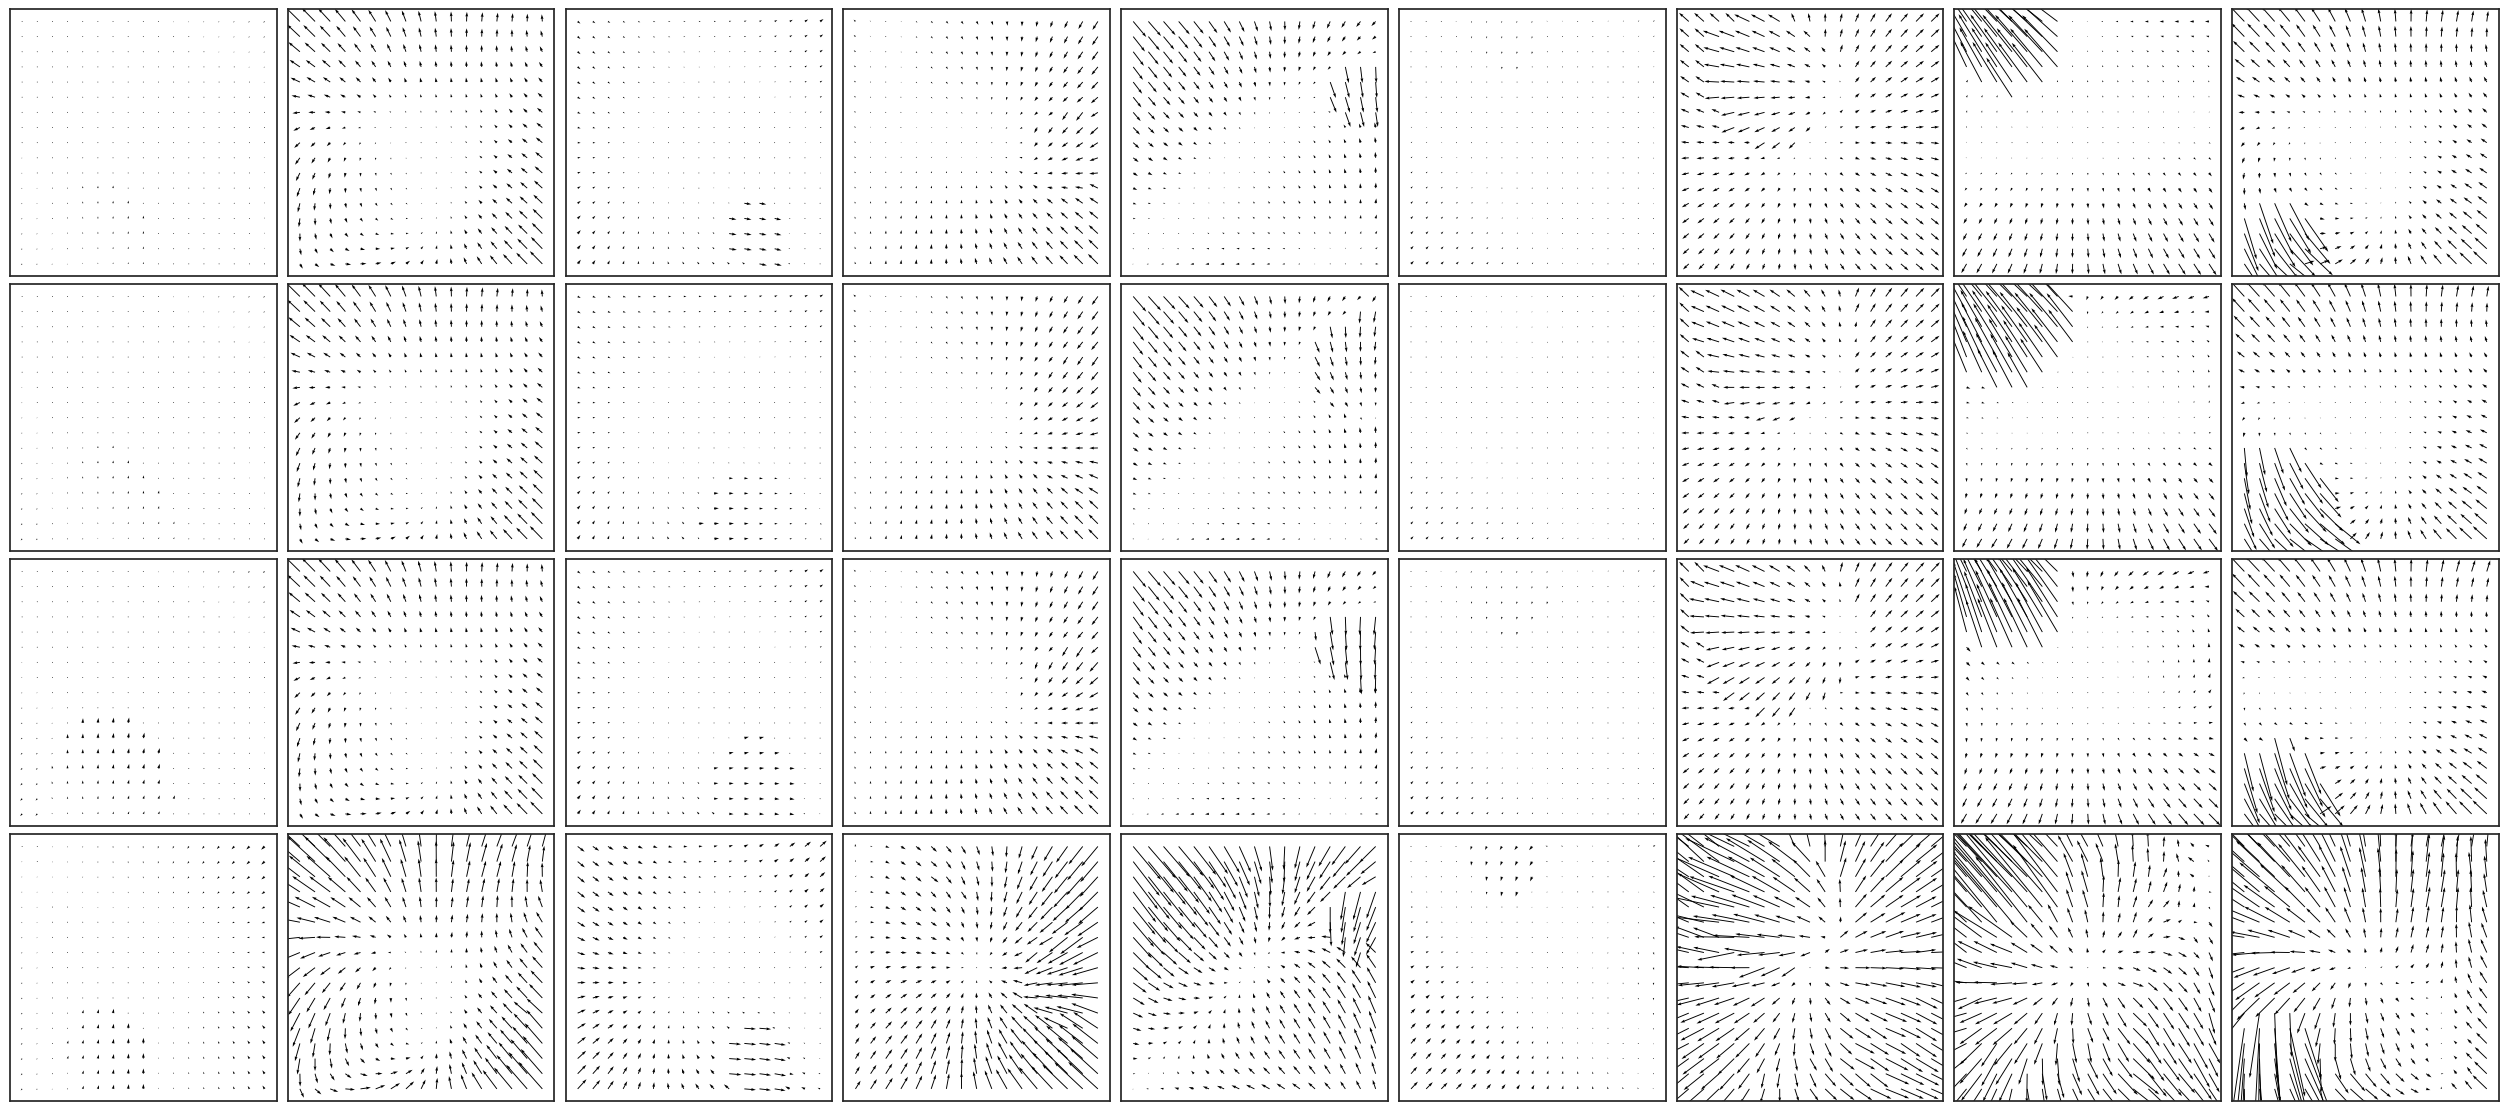

In [119]:
fig, axes = show_opticflow_row(x2p['dec'][:, 27:36], figsize=(25, 11), scale=[10] * 9)

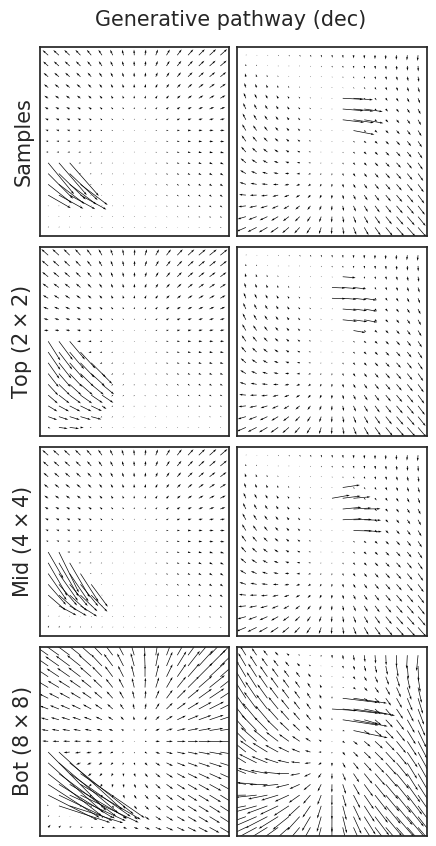

In [129]:
fig, axes = show_opticflow_row(x2p['dec'][:, [7, 61]], figsize=(4.25, 8), scale=[4, 5], display=False)

sup = fig.suptitle('Generative pathway (dec)', fontsize=15, y=1.04, x=0.53)
axes[0, 0].set_ylabel('Samples', fontsize=15)
axes[1, 0].set_ylabel('Top ' + r"$\left(2 \times 2\right)$", fontsize=15)
axes[2, 0].set_ylabel('Mid ' + r"$\left(4 \times 4\right)$", fontsize=15)
axes[3, 0].set_ylabel('Bot ' + r"$\left(8 \times 8\right)$", fontsize=15)
fig.savefig(
    fname=pjoin(fig_dir, 'lesion_dec_2xsamples.pdf'),
    bbox_extra_artists=[sup],
    bbox_inches='tight',
)
display(fig)

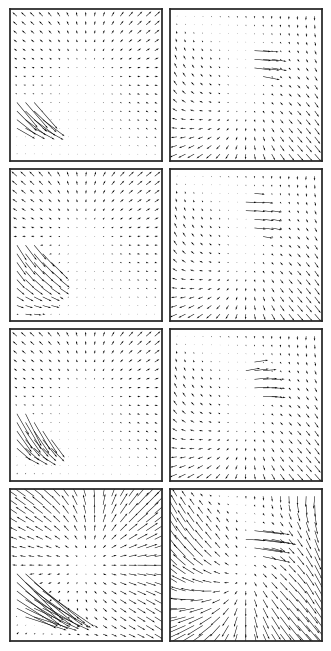

In [149]:
fig, axes = show_opticflow_row(x2p['dec'][:, [7, 61]], figsize=(3.2, 6.4), scale=[4, 5])
fig.savefig(
    fname=pjoin(fig_dir, 'lesion_dec_2xsamples_nolabels.pdf'),
    bbox_inches='tight',
)

In [160]:
final = np.concatenate([
    x2p['enc'][:, [13]],
    x2p['dec'][:, [13]],
], axis=1)
final = np.transpose(final, (1, 0, 2, 3, 4))
final.shape

(2, 4, 2, 17, 17)

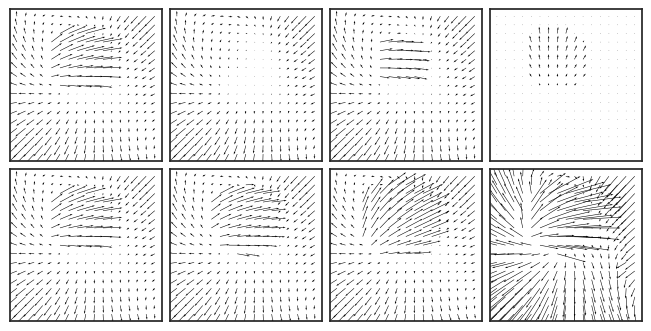

In [181]:
scale = np.ones((2, 4)) * 5
scale[0, -1] = 4
fig, axes = show_opticflow_row(final, figsize=(6.4, 3.2), scale=scale)
fig.savefig(
    fname=pjoin(fig_dir, 'lesion_encdec_final.pdf'),
    bbox_inches='tight',
)

In [182]:
final = torch.tensor(final)

In [183]:
final.shape

torch.Size([2, 4, 2, 17, 17])

In [191]:
d = 1 - F.cosine_similarity(final[0, 0], final[1, 3], dim=0)

In [193]:
d.size()

torch.Size([17, 17])

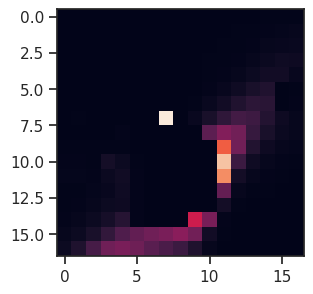

In [192]:
plt.imshow(d)

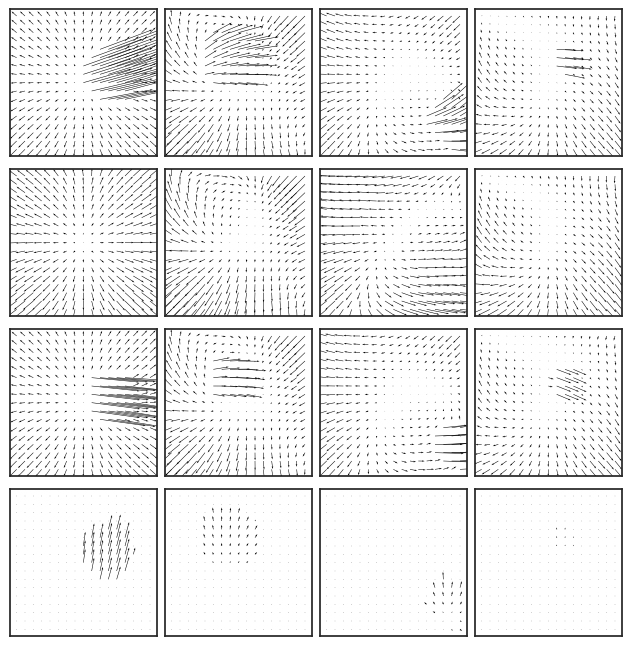

In [151]:
fig, axes = show_opticflow_row(x2p['enc'][:, [25, 13, 6, 61]], figsize=(6.2, 6.4), scale=[4, 3, 4, 5])
# fig.savefig(
  #   fname=pjoin(fig_dir, 'lesion_enc_2xsamples_nolabels.pdf'),
    # bbox_inches='tight',
# )

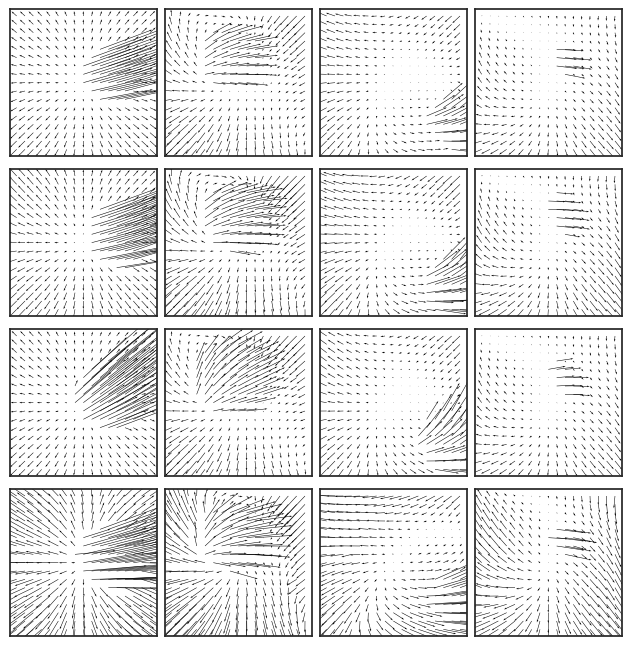

In [152]:
fig, axes = show_opticflow_row(x2p['dec'][:, [25, 13, 6, 61]], figsize=(6.2, 6.4), scale=[4, 3, 4, 5])

## Scratch pad 2

In [8]:
%%time

enc = lesion_results(tr, 'enc')
# dec = lesion_results('dec', tr)
# both = lesion_results(['enc', 'dec'], tr)

CPU times: user 1min 46s, sys: 3.2 s, total: 1min 49s
Wall time: 1min 49s


In [9]:
r2_z_lesion_enc = {}
for s in [2, 4, 8]:
    pred = lr_true.predict(enc['z_lesion'][s])
    r2_z_lesion_enc[s] = sk_metric.r2_score(
        y_pred=pred,
        y_true=g['tst'],
        multioutput='raw_values',
    )

In [10]:
r2_z_lesion_enc

{2: array([-6.48154508e-01,  1.46326464e-02,  4.83634375e-01,  2.39763011e-01,
         5.92368339e-01, -5.24863407e+00, -4.72042721e+00, -2.12355825e+01,
        -1.02565773e+01, -7.76771453e+00, -2.71789934e+01]),
 4: array([ 0.29048742,  0.49764908,  0.409129  ,  0.39342912,  0.53621843,
        -0.06677788, -1.42255753, -2.93380617, -2.41546425, -3.14989231,
        -7.26558175]),
 8: array([ 0.96695788,  0.96743496, -0.03203398, -0.14179882, -0.06381044,
         0.84442309,  0.90111062,  0.63890948, -0.41876047,  0.0378201 ,
        -0.02258056])}

In [11]:
{s: v.mean() for s, v in r2_z_lesion_enc.items()}

{2: -6.884153189750575, 4: -1.3751969845742982, 8: 0.3343338064404897}

In [12]:
r2_z_infer_enc = {}
for s in [2, 4, 8]:
    pred = lr_true.predict(enc['z_infer'][s])
    r2_z_infer_enc[s] = sk_metric.r2_score(
        y_pred=pred,
        y_true=g['tst'],
        multioutput='raw_values',
    )

In [13]:
r2_z_infer_enc

{2: array([ 0.5245794 ,  0.48156381,  0.74346742,  0.73250017,  0.87247015,
        -0.06745285, -0.0687742 , -0.61500921, -0.20563323, -0.08851358,
        -0.27157463]),
 4: array([ 0.80699683,  0.84120975,  0.91365297,  0.87626024,  0.93711994,
         0.76215626,  0.77723421, -0.36773197,  0.58048054,  0.32654047,
         0.17622028]),
 8: array([ 0.57283495,  0.43883275, -0.00894226, -0.00458721, -0.01238849,
         0.65561995,  0.56750111, -0.53552495, -0.04152576,  0.68637963,
         0.49208461])}

In [14]:
{s: v.mean() for s, v in r2_z_infer_enc.items()}

{2: 0.1852384773226481, 4: 0.602739956143835, 8: 0.25548039402741457}

In [72]:
s = 8
pred = lr_true.predict(enc['z_infer'][s])

In [73]:
err = (pred - g['tst']) ** 2
err.shape

(75000, 11)

In [79]:
i = 4
select_lbl[i]

'slf_v_z'

In [80]:
ids = np.argsort(err[:, i])

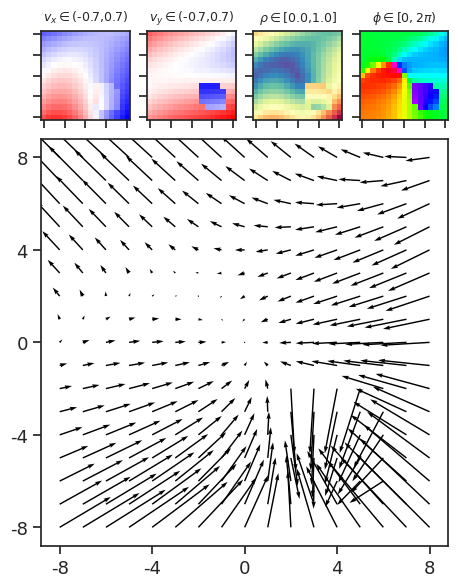

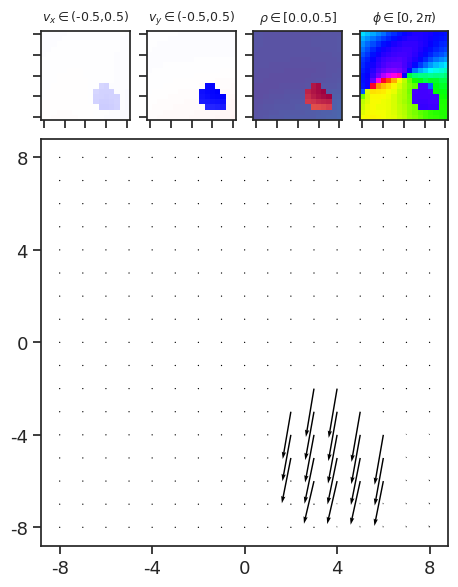

In [83]:
scale = 4
sample_i = ids[-2000]

show_opticflow_full(tr.dl_tst.dataset.x[sample_i], scale=scale);
show_opticflow_full(enc['y_lesion'][s][sample_i], scale=scale);

In [20]:
epe_enc = {
    s: v.mean() for s, v in
    enc['epe_lesion'].items()
}
epe_enc = {
    'true': enc['epe'].mean(),
    **epe_enc
}
print(epe_enc)

{'true': 0.595171, 2: 18.740683, 4: 12.264772, 8: 57.97698}

In [21]:
epe_dec = {
    s: v.mean() for s, v in
    dec['epe_lesion'].items()
}
epe_dec = {
    'true': dec['epe'].mean(),
    **epe_dec
}
print(epe_dec)

{'true': 0.595171, 2: 12.264142, 4: 15.868749, 8: 105.72088}

In [22]:
epe_both = {
    s: v.mean() for s, v in
    both['epe_lesion'].items()
}
epe_both = {
    'true': both['epe'].mean(),
    **epe_both
}
print(epe_both)

{'true': 0.595171, 2: 7.1885815, 4: 3.0548854, 8: 53.83392}

In [45]:
ids = np.argsort(dec['epe_lesion'][8])
ids

array([66169, 32735, 52897, ..., 70362, 30182, 41692])

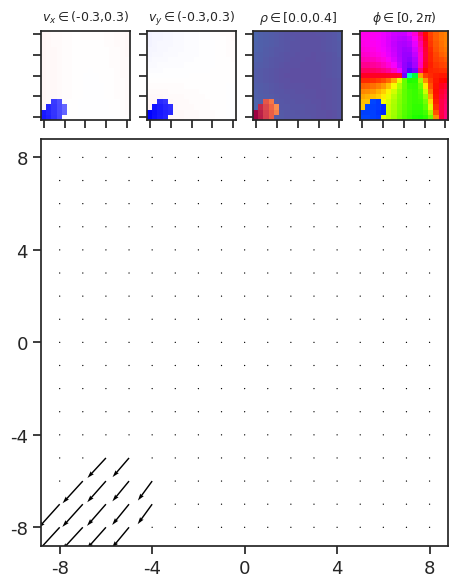

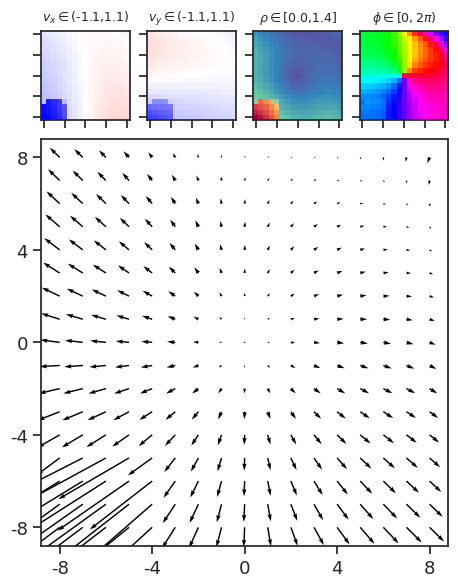

In [46]:
i = -2
scale = 5
show_opticflow_full(tr.dl_vld.dataset.x[ids[i]], scale=scale)
show_opticflow_full(dec['y_lesion'][8][ids[i]], scale=scale);

In [47]:
ids = np.argsort(enc['epe_lesion'][8])
ids

array([ 6141, 48198, 72876, ..., 41710, 32541, 67184])

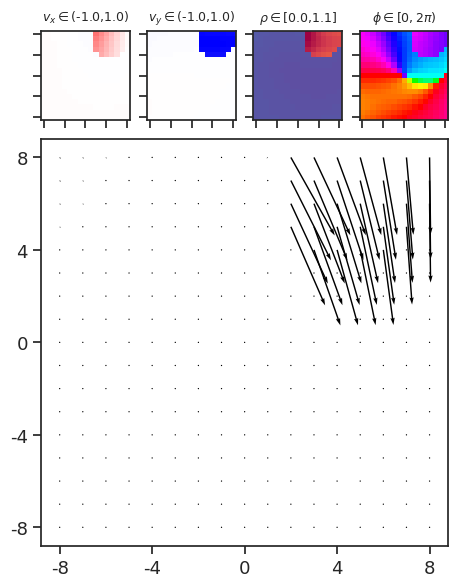

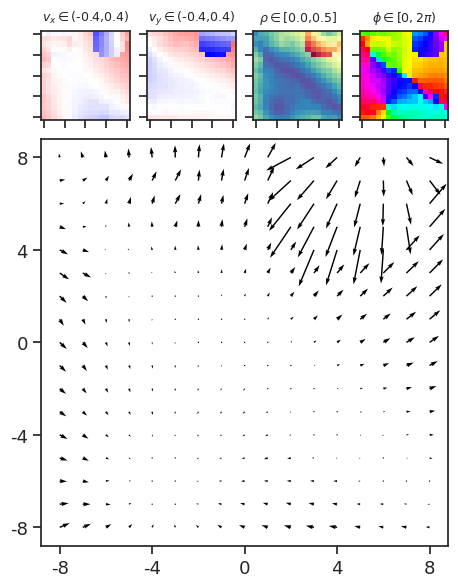

In [51]:
i = -3
scale = 5
show_opticflow_full(tr.dl_vld.dataset.x[ids[i]], scale=scale)
show_opticflow_full(enc['y_lesion'][8][ids[i]], scale=scale);

In [52]:
ids = np.argsort(both['epe_lesion'][8])
ids

array([10557, 14124, 66552, ..., 55965, 38595, 55164])

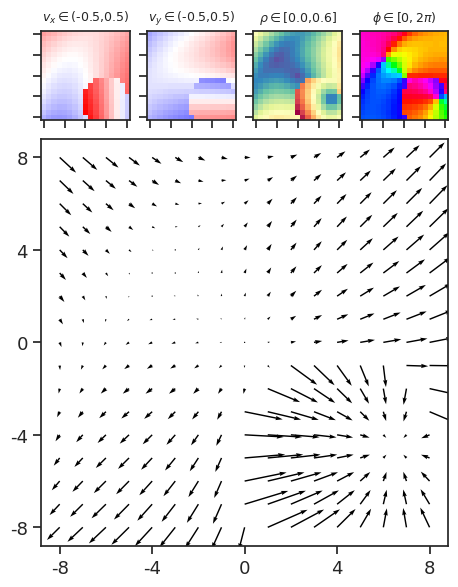

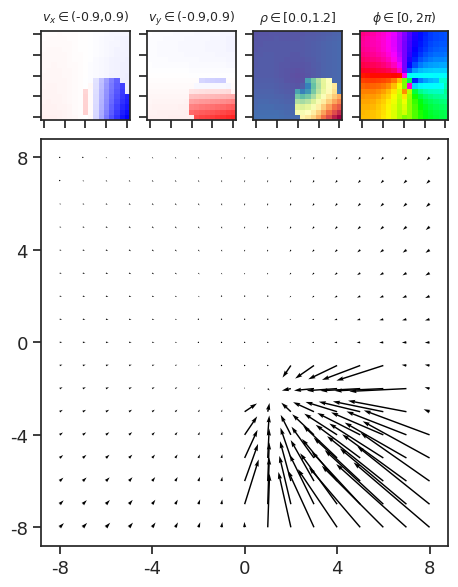

In [54]:
i = -1
scale = 5
show_opticflow_full(tr.dl_vld.dataset.x[ids[i]], scale=scale)
show_opticflow_full(both['y_lesion'][8][ids[i]], scale=scale);

## TODO:

predict g from z, how does lesion affect g preds?

## scratch pad (ignore)

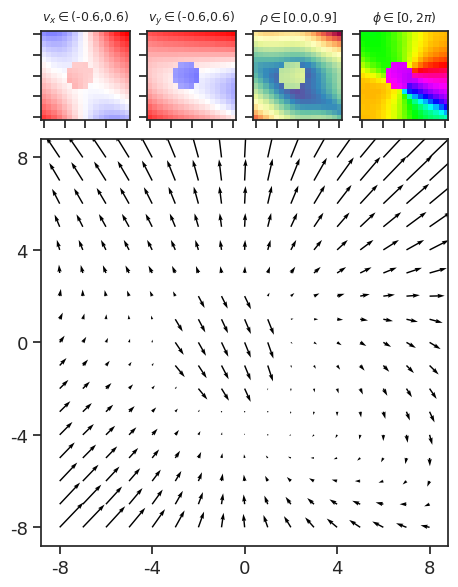

In [4]:
x, n = next(iter(tr.dl_vld))
show_opticflow_full(x[0]);

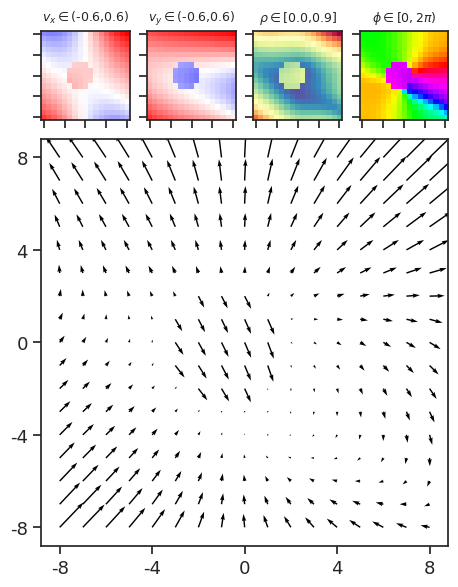

In [5]:
"""latents, ftr, y, q, p = tr.model.xtract_ftr(x)
show_opticflow_full(y[0]);"""

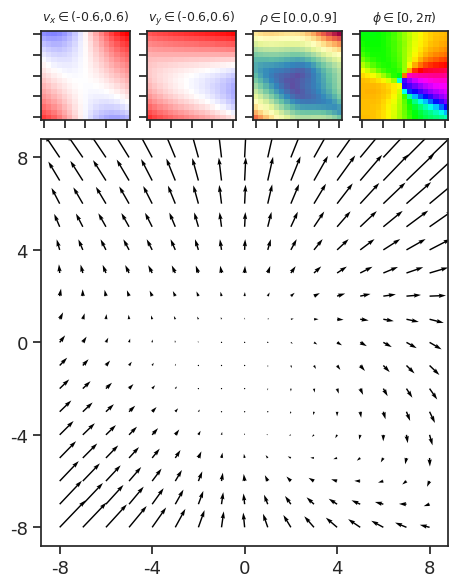

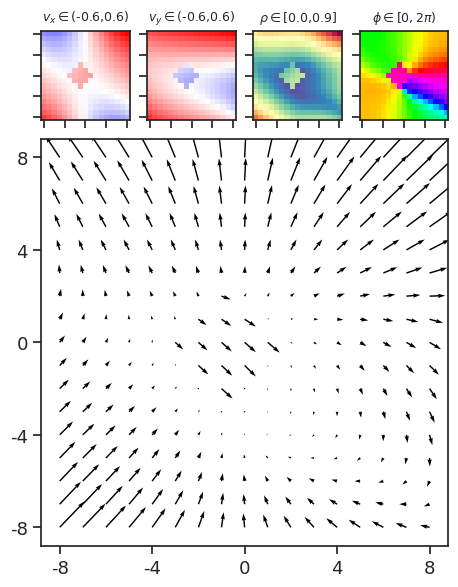

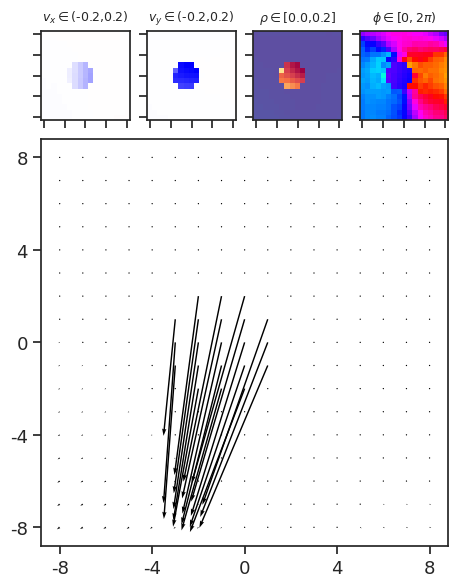

In [14]:
"""for k, v in lesion.items():
    latents, ftr, y, q, p = tr.model.xtract_ftr(
        x=x, lesion_enc=v)
    show_opticflow_full(y[0]);"""

In [5]:
scales, _ = tr.model.latent_scales()
lesion = {
    s: [s == item for item in scales]
    for s in np.unique(scales)
}

In [6]:
results_enc, results_dec, results_both = {}, {}, {}
for k, v in lesion.items():
    results_enc[k] = tr.model.xtract_ftr(
        x=x, lesion_enc=v)[2]
    results_dec[k] = tr.model.xtract_ftr(
        x=x, lesion_dec=v)[2]
    results_both[k] = tr.model.xtract_ftr(
        x=x, lesion_enc=v, lesion_dec=v)[2]

x2p_enc = [x] + list(results_enc.values())
x2p_enc = to_np(torch.stack(x2p_enc))
x2p_dec = [x] + list(results_dec.values())
x2p_dec = to_np(torch.stack(x2p_dec))
x2p_both = [x] + list(results_both.values())
x2p_both = to_np(torch.stack(x2p_both))

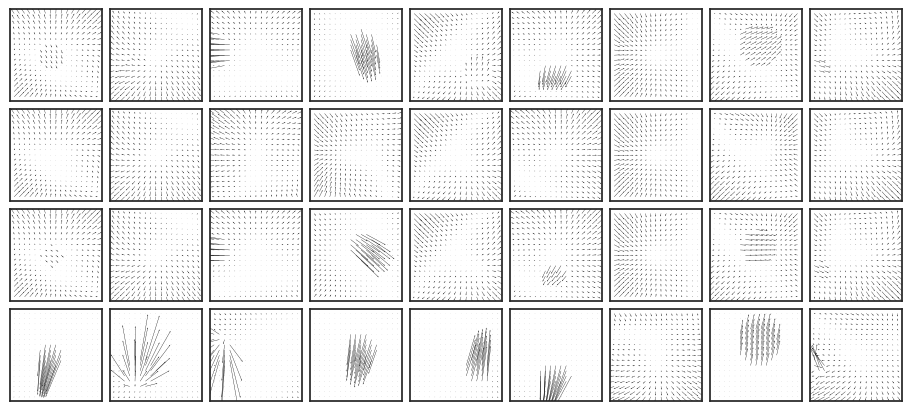

In [7]:
fig, axes = show_opticflow_row(x2p_enc[:, :9])

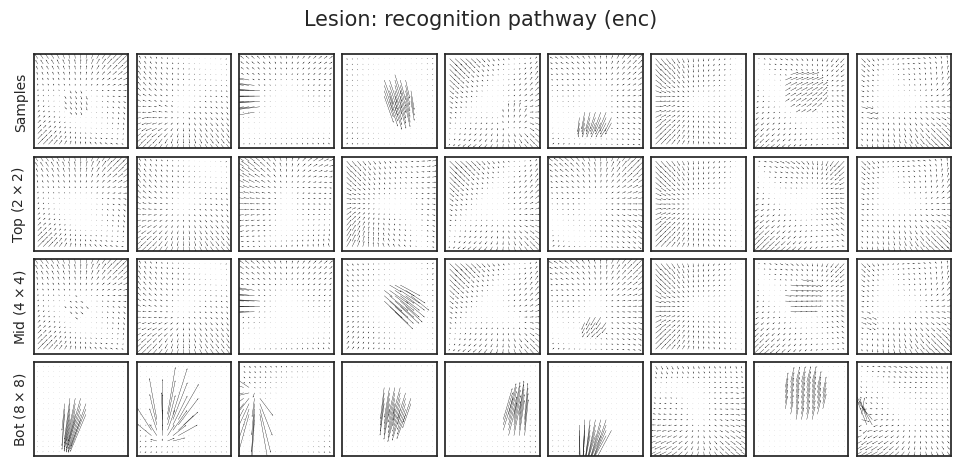

In [8]:
fig, axes = show_opticflow_row(x2p_enc[:, :9], figsize=(9.5, 4.1), display=False)
sup = fig.suptitle('Lesion: recognition pathway (enc)', fontsize=15, y=1.1)
axes[0, 0].set_ylabel('Samples', fontsize=10)
axes[1, 0].set_ylabel('Top ' + r"$\left(2 \times 2\right)$", fontsize=10)
axes[2, 0].set_ylabel('Mid ' + r"$\left(4 \times 4\right)$", fontsize=10)
axes[3, 0].set_ylabel('Bot ' + r"$\left(8 \times 8\right)$", fontsize=10)
fig.savefig(
    fname=pjoin(fig_dir, 'lesion_enc.pdf'),
    bbox_extra_artists=[sup],
    bbox_inches='tight',
)
display(fig)

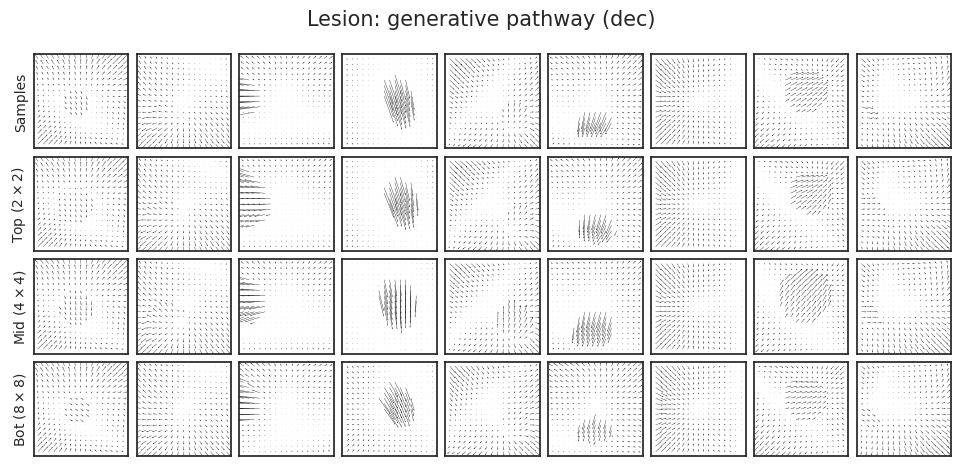

In [9]:
fig, axes = show_opticflow_row(x2p_dec[:, :9], figsize=(9.5, 4.1), display=False)
sup = fig.suptitle('Lesion: generative pathway (dec)', fontsize=15, y=1.1)
axes[0, 0].set_ylabel('Samples', fontsize=10)
axes[1, 0].set_ylabel('Top ' + r"$\left(2 \times 2\right)$", fontsize=10)
axes[2, 0].set_ylabel('Mid ' + r"$\left(4 \times 4\right)$", fontsize=10)
axes[3, 0].set_ylabel('Bot ' + r"$\left(8 \times 8\right)$", fontsize=10)
fig.savefig(
    fname=pjoin(fig_dir, 'lesion_dec.pdf'),
    bbox_extra_artists=[sup],
    bbox_inches='tight',
)
display(fig)

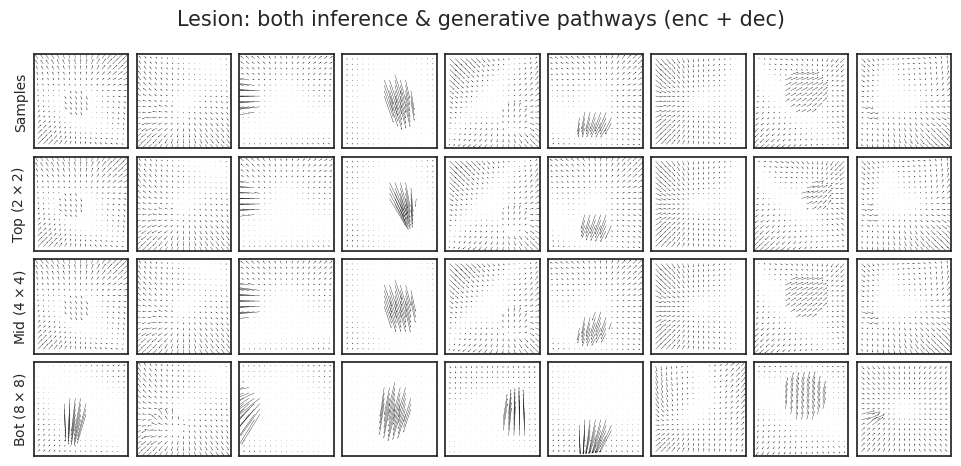

In [10]:
fig, axes = show_opticflow_row(x2p_both[:, :9], figsize=(9.5, 4.1), display=False)
sup = fig.suptitle('Lesion: both inference & generative pathways (enc + dec)', fontsize=15, y=1.1)
axes[0, 0].set_ylabel('Samples', fontsize=10)
axes[1, 0].set_ylabel('Top ' + r"$\left(2 \times 2\right)$", fontsize=10)
axes[2, 0].set_ylabel('Mid ' + r"$\left(4 \times 4\right)$", fontsize=10)
axes[3, 0].set_ylabel('Bot ' + r"$\left(8 \times 8\right)$", fontsize=10)
fig.savefig(
    fname=pjoin(fig_dir, 'lesion_both.pdf'),
    bbox_extra_artists=[sup],
    bbox_inches='tight',
)
display(fig)

In [22]:
rng = get_rng()

In [23]:
n = 9
ids = rng.choice(x2p_enc.shape[1], size=n)

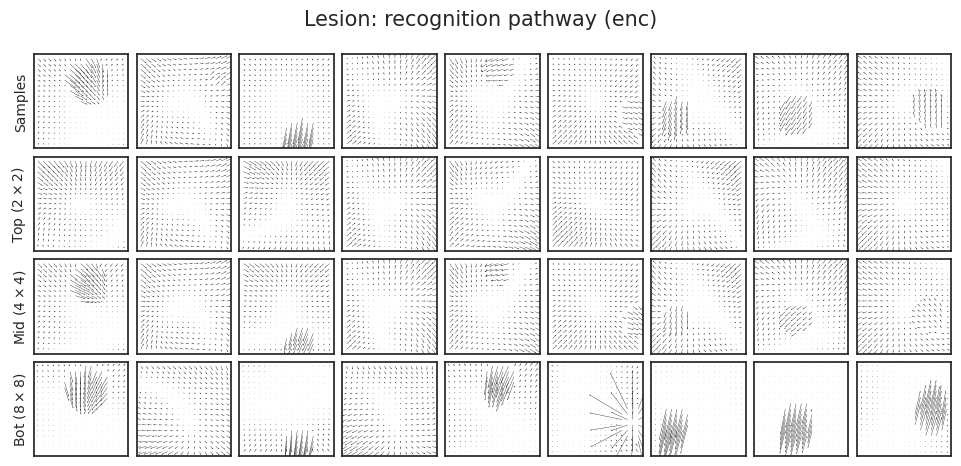

In [40]:
fig, axes = show_opticflow_row(
    x2p_enc[:, ids],
    figsize=(9.5, 4.1),
    display=False,
)
sup = fig.suptitle('Lesion: recognition pathway (enc)', fontsize=15, y=1.1)
axes[0, 0].set_ylabel('Samples', fontsize=10)
axes[1, 0].set_ylabel('Top ' + r"$\left(2 \times 2\right)$", fontsize=10)
axes[2, 0].set_ylabel('Mid ' + r"$\left(4 \times 4\right)$", fontsize=10)
axes[3, 0].set_ylabel('Bot ' + r"$\left(8 \times 8\right)$", fontsize=10)
# fig.savefig(
#     fname=pjoin(fig_dir, 'lesion_enc.pdf'),
#     bbox_extra_artists=[sup],
#     bbox_inches='tight',
# )
display(fig)

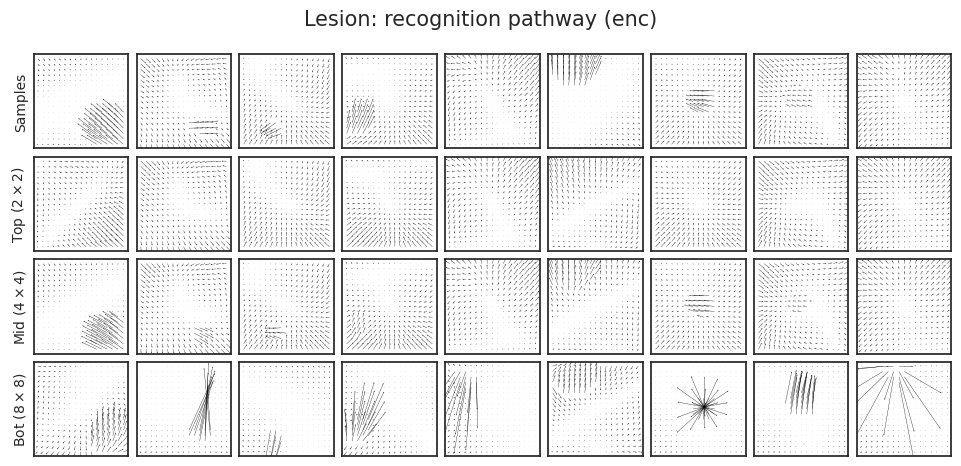

array([ 56, 315, 585, 441, 456, 430, 471, 307,  76])

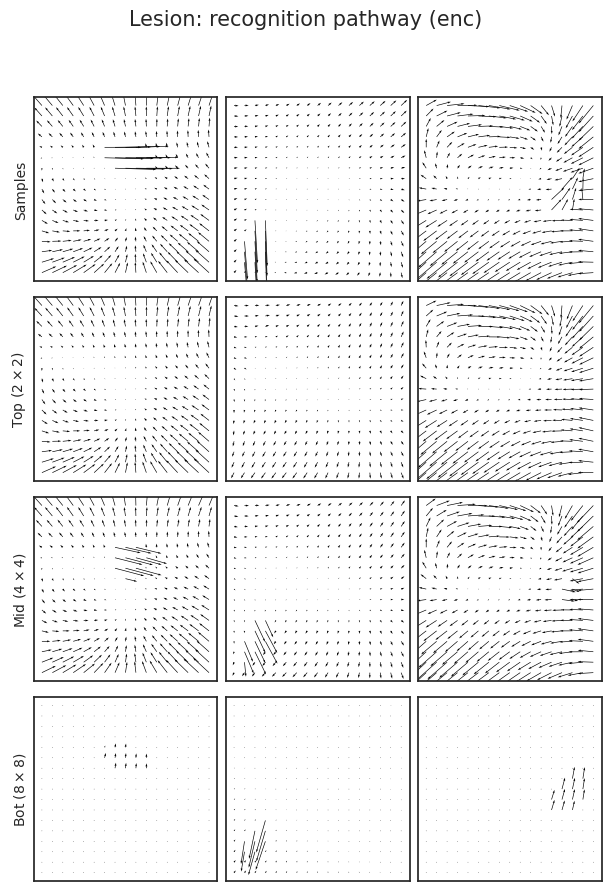

In [39]:
fig, axes = show_opticflow_row(
    x2p_enc[:, [514, 156, 18]],
    figsize=(6, 8),
    display=False,
    scale=3,
)
sup = fig.suptitle('Lesion: recognition pathway (enc)', fontsize=15, y=1.1)
axes[0, 0].set_ylabel('Samples', fontsize=10)
axes[1, 0].set_ylabel('Top ' + r"$\left(2 \times 2\right)$", fontsize=10)
axes[2, 0].set_ylabel('Mid ' + r"$\left(4 \times 4\right)$", fontsize=10)
axes[3, 0].set_ylabel('Bot ' + r"$\left(8 \times 8\right)$", fontsize=10)
display(fig)

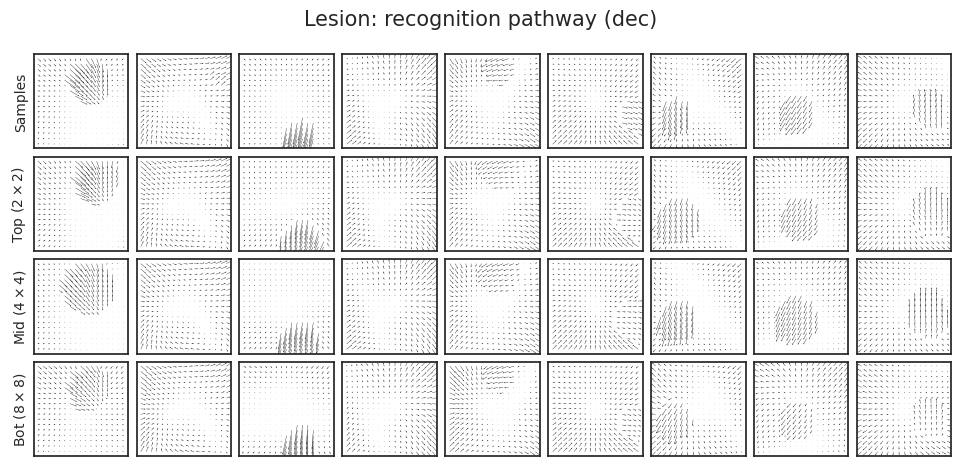

In [41]:
fig, axes = show_opticflow_row(
    x2p_dec[:, ids],
    figsize=(9.5, 4.1),
    display=False,
)
sup = fig.suptitle('Lesion: recognition pathway (dec)', fontsize=15, y=1.1)
axes[0, 0].set_ylabel('Samples', fontsize=10)
axes[1, 0].set_ylabel('Top ' + r"$\left(2 \times 2\right)$", fontsize=10)
axes[2, 0].set_ylabel('Mid ' + r"$\left(4 \times 4\right)$", fontsize=10)
axes[3, 0].set_ylabel('Bot ' + r"$\left(8 \times 8\right)$", fontsize=10)
# fig.savefig(
#     fname=pjoin(fig_dir, 'lesion_enc.pdf'),
#     bbox_extra_artists=[sup],
#     bbox_inches='tight',
# )
display(fig)